# Face Recognition on a subset of the Labeled Faces in the Wild dataset

In [1]:
%pylab inline

import pylab as pl
import numpy as np

Populating the interactive namespace from numpy and matplotlib


## The LFW dataset

LFW 是 Labeled Faces in the Wild 的缩写，数据集在 http://vis-www.cs.umass.edu/lfw/。

`fetch_lfw_people` 会自动下载数据集，默认保存在 `~/scikit_learn_data` 目录下。下载完成后会对数据进行处理。目前的数据集大概 200 MB，所以第一次运行需要较长的时间下载数据。另外，还需要 [Python Imaging Library](http://www.pythonware.com/products/pil) 来处理 jpeg 图像。

返回的数据格式如下：

```
Returns
-------
dataset : dict-like object with the following attributes:

dataset.data : numpy array of shape (13233, 2914)
    Each row corresponds to a ravelled face image of original size 62 x 47
    pixels. Changing the ``slice_`` or resize parameters will change the shape
    of the output.

dataset.images : numpy array of shape (13233, 62, 47)
    Each row is a face image corresponding to one of the 5749 people in
    the dataset. Changing the ``slice_`` or resize parameters will change the shape
    of the output.

dataset.target : numpy array of shape (13233,)
    Labels associated to each face image. Those labels range from 0-5748
    and correspond to the person IDs.

dataset.DESCR : string
    Description of the Labeled Faces in the Wild (LFW) dataset.
```

详细信息可参阅 `fetch_lfw_people` 的文档。

In [65]:
from sklearn.datasets import fetch_lfw_people

# 只载入图片数量不小于 min_faces_per_person 的人的数据，并且缩放到原图的 0.4 大小
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

### 显示数据集信息

n_samples: 训练数据集个数

n_features: 特征个数，即图像的象素个数

n_classes: 训练数据的类别个数，即这些图片包含几个人

h, w: 图像的高度和宽度

In [66]:
X = lfw_people.data
y = lfw_people.target
names = lfw_people.target_names

n_samples, n_features = X.shape
_, h, w = lfw_people.images.shape
n_classes = len(names)

print("n_samples: {}".format(n_samples))
print("n_features: {} (={}x{})".format(n_features, w, h))
print("n_classes: {}".format(n_classes))
print("-" * 80)
print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))
print("images.shape: {}".format(lfw_people.images.shape))
print("names: {}".format(names))
print("-" * 80)
print("X.dtype: {}".format(X.dtype))
print("y.dtype: {}".format(y.dtype))
print("images.dtype: {}".format(lfw_people.images.dtype))
print("-" * 80)
print("y[0:20]: {}".format(y[0:20]))
print("-" * 80)

n_samples: 1288
n_features: 1850 (=37x50)
n_classes: 7
--------------------------------------------------------------------------------
X.shape: (1288, 1850)
y.shape: (1288,)
images.shape: (1288, 50, 37)
names: ['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Tony Blair']
--------------------------------------------------------------------------------
X.dtype: float32
y.dtype: int32
images.dtype: float32
--------------------------------------------------------------------------------
y[0:20]: [5 6 3 1 0 1 3 4 3 0 3 2 3 1 4 3 3 3 3 3]
--------------------------------------------------------------------------------


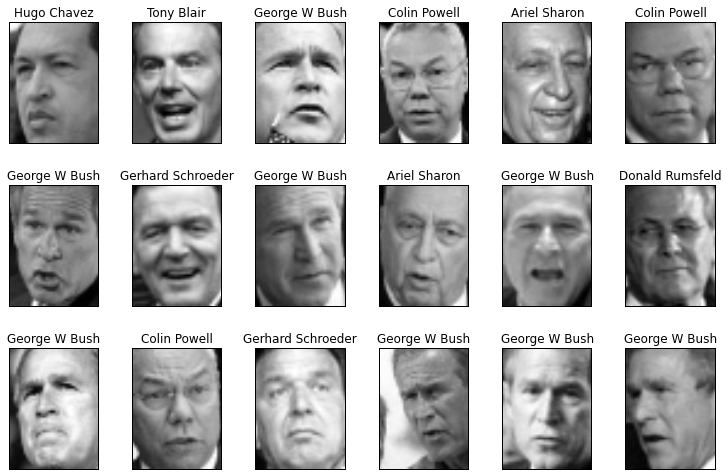

In [67]:
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    pl.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    pl.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        pl.subplot(n_row, n_col, i + 1)
        pl.imshow(images[i].reshape((h, w)), cmap=pl.cm.gray)
        pl.title(titles[i], size=12)
        pl.xticks(())
        pl.yticks(())

plot_gallery(X, names[y], h, w)

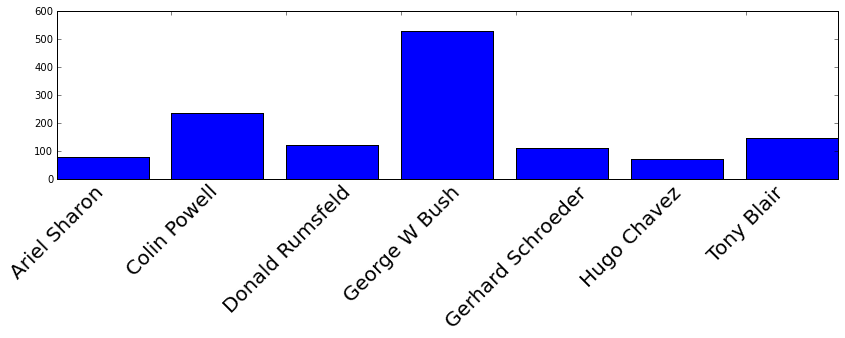

In [68]:
pl.figure(figsize=(14, 3))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.xticks(y_unique,  names[y_unique])
locs, labels = pl.xticks()
pl.setp(labels, rotation=45, size=20)
_ = pl.bar(y_unique, counts)

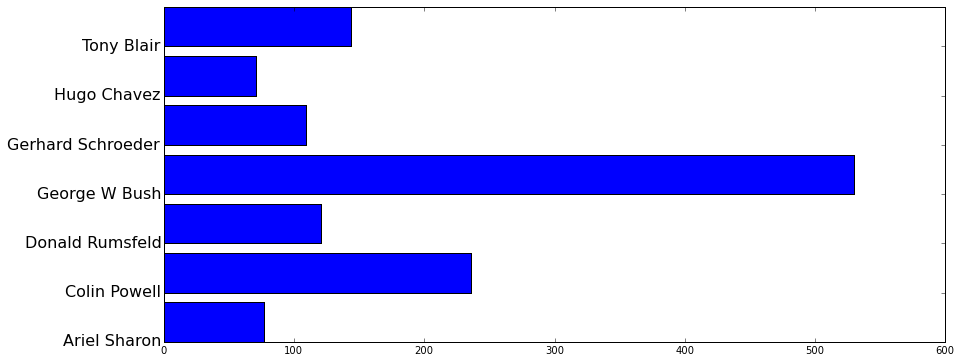

In [69]:
pl.figure(figsize=(14, 6))

y_unique = np.unique(y)
counts = [(y == i).sum() for i in y_unique]

pl.yticks(y_unique, names[y_unique])
locs, labels = pl.yticks()
pl.setp(labels, size=16)
_ = pl.barh(y_unique, counts)

## 数据集分隔

我们需要把数据集分隔成两部分，一部分用来训练模型，另外一部分用来测试模型的正确性。

In [70]:
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

## 特征提取

Unsupervised Feature Extraction with Randomized PCA

为了减少模型训练时的计算量，我们需要对原始图片数据进特征提取操作，这里利用主成分分析法 (PCA) 来完成非监督特征提取 (unsupervised feature extraction) 。我们使用 `sklearn.decomposition.RandomizedPCA` 来完成这个任务。

完成特征提取后，再使用正交投射，反原数据投射到这些提取出来的特征值上。使原来原来 1850 个特征转化为 150 个特征。

In [86]:
from sklearn.decomposition import RandomizedPCA

n_components = 100

print "Extracting the top %d eigenfaces from %d faces" % (
    n_components, X_train.shape[0])

pca = RandomizedPCA(n_components=n_components, whiten=True)

%time pca.fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 100 eigenfaces from 966 faces
Wall time: 622 ms


In [87]:
print('X_train.shape: {}'.format(X_train.shape))
print('eigenfaces.shape: {}'.format(eigenfaces.shape))

X_train.shape: (966, 1850)
eigenfaces.shape: (100, 50, 37)


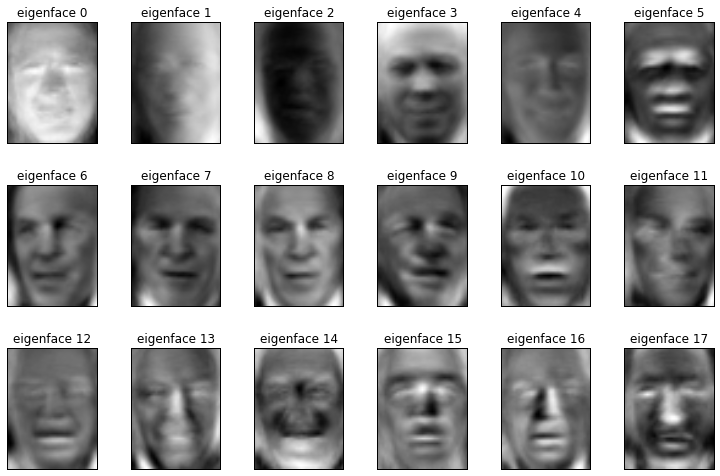

In [88]:
# Let's plot the gallery of the most significant eigenfaces:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

把输入数据正交投射到主特征数据上

Projecting the input data on the eigenfaces orthonormal basis:

In [89]:
X_train_pca = pca.transform(X_train)
print('X_train_pca.shape: {}'.format(X_train_pca.shape))

X_train_pca.shape: (966, 100)


## 训练高斯核函数的支持向量机

Training a Gaussian Kernel Support Vector Machine

Let's now train a Kernel Support Vector Machine on the projected data. We perform an automated parameter search to find good values for Gamma and C:

In [90]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf', class_weight='auto')

svm

SVC(C=1.0, cache_size=200, class_weight='auto', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

为了提高算法的准确性，我们把训练数据集随机分成两部分，一部分用来训练 SVM，另外一部分做来计算 F1 Score。分别做 5 次。

在 Windows 下使用 Python 2.7 运行的同学可能会碰到这样的错误:

```
AssertionError:   File "C:\Python27\lib\multiprocessing\forking.py", line 488, in prepare  
__main__                                                                                   
    assert main_name not in sys.modules, main_name                                         
AssertionError: __main__                                                                   
Traceback (most recent call last):                                                         
  File "<string>", line 1, in <module>                                                     
  File "C:\Python27\lib\multiprocessing\forking.py", line 380, in main                     
    prepare(preparation_data)                                                              
  File "C:\Python27\lib\multiprocessing\forking.py", line 488, in prepare                  
    assert main_name not in sys.modules, main_name
```

可以参考 https://hg.python.org/cpython/rev/5d88c1d413b9/ 来修改 `C:\Python27\Lib\multiprocessing\forking.py`。这个是 Python 2.7 在 Windows 下的一个多进程的 Bug。


Unfortunately an SVM is very sensitive to the parameters C and gamma and it's very unlikely that the default parameters will yield a good predictive accurracy:

In [91]:
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.cross_validation import cross_val_score

cv = StratifiedShuffleSplit(y_train, test_size=0.20, n_iter=5)

%time svm_cv_scores = cross_val_score(svm, X_train_pca, y_train, scoring='f1', cv=cv, n_jobs=2)
svm_cv_scores

Wall time: 2.87 s


array([ 0.89168699,  0.84602583,  0.84370238,  0.80357779,  0.82451675])

In [92]:
svm_cv_scores.mean(), svm_cv_scores.std()

(0.84190194837979804, 0.029222543417825157)

## 参数调试

利用交叉验证数据集对 SVM 算法的参数 C/gamma 进行调整，选择一组最好的参数。

param_grid: C/gamma 参数对集合

cv: 利用 `cv = StratifiedShuffleSplit(y_train, test_size=0.20, n_iter=5)` 随机生成的五份训练数据集和交叉验证数据集。

Data-driven hyper-parameters tuning using a Cross-Validated Grid Search

Fortunately we can automate the search for the best combination of parameters:

In [93]:
from sklearn.grid_search import GridSearchCV

param_grid = {
    'C': [1e3, 3e3, 1e4, 3e4, 1e5],
    'gamma': [0.0001, 0.0003, 0.001, 0.003, 0.01, 0.1],
}

clf = GridSearchCV(svm, param_grid, scoring='f1', cv=cv, n_jobs=2)

In [94]:
%time clf = clf.fit(X_train_pca, y_train)

print("Best estimator found by randomized hyper parameter search:")
print(clf.best_params_)
print("Best parameters validation score: {:.3f}".format(clf.best_score_))

Wall time: 19.9 s
Best estimator found by randomized hyper parameter search:
{'C': 100000.0, 'gamma': 0.003}
Best parameters validation score: 0.834


C:\Python27\lib\site-packages\sklearn\utils\class_weight.py:62: DeprecationWarning: The class_weight='auto' heuristic is deprecated in 0.17 in favor of a new heuristic class_weight='balanced'. 'auto' will be removed in 0.19
  " 0.19", DeprecationWarning)


## 使用最优参数在测试数据集中验证

Final evaluation of the best model on the held-out test set

Let's start with a qualitative inspection of the some of the predictions:

In [95]:
# 从测试数据集中提取特征
X_test_pca = pca.transform(X_test)
# 计算测试数据集的预测值
y_pred = clf.predict(X_test_pca)

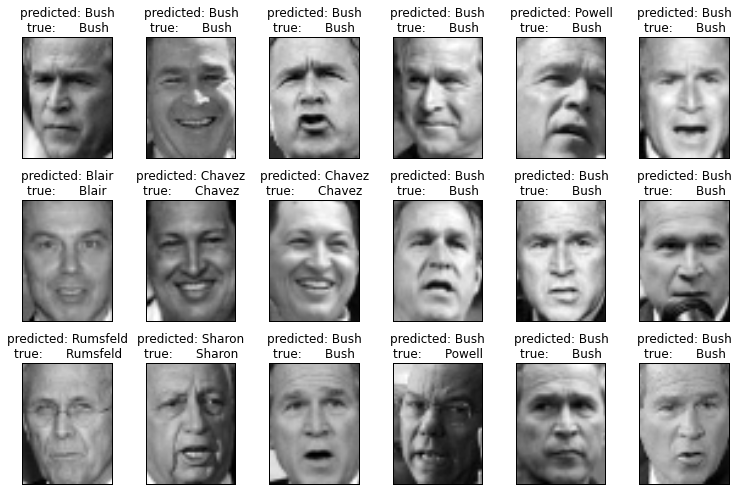

In [96]:
def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

prediction_titles = [title(y_pred, y_test, names, i)
                     for i in range(y_pred.shape[0])]

plot_gallery(X_test, prediction_titles, h, w)

### 准确率，召回率，F1-Score 来评价分类算法的性能

预测数据/实际数据  | 实际恶性肿瘤      | 实际良性肿瘤
-----------------|------------------|--------------
预测恶性肿瘤      | TruePositive   | FalsePositive
预测良性肿瘤      | FalseNegative  | TrueNegative

$$
Precision = \frac{TruePosition}{TruePosition + FalsePositive}
$$

$$
Recall = \frac{TruePositive}{TruePositive + FalseNegative}
$$

$$
F_1Score = 2 \frac{PR}{P + R}
$$


In [97]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.86      0.86      0.86        21
     Colin Powell       0.76      0.88      0.82        48
  Donald Rumsfeld       0.82      0.73      0.78        45
    George W Bush       0.85      0.90      0.87       127
Gerhard Schroeder       0.90      0.78      0.84        23
      Hugo Chavez       0.89      0.74      0.81        23
       Tony Blair       0.82      0.77      0.79        35

      avg / total       0.84      0.84      0.83       322



### 混淆矩阵

混淆矩阵是另外一个评估分类算法性能的工具。怎么看混淆矩阵？对角线上的元素表示测试数据集中正确分类的数据。对角线之外的数值，表示被错误分类到别的类别的数据。


Compute confusion matrix to evaluate the accuracy of a classification

By definition a confusion matrix :math:`C` is such that :math:`C_{i, j}`
is equal to the number of observations known to be in group :math:`i` but
predicted to be in group :math:`j`.

In [98]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred, labels=range(n_classes))
print(cm)

[[ 18   1   1   1   0   0   0]
 [  1  42   1   2   0   0   2]
 [  2   1  33   6   0   1   2]
 [  0   7   4 114   0   1   1]
 [  0   0   1   4  18   0   0]
 [  0   1   0   3   1  17   1]
 [  0   3   0   4   1   0  27]]


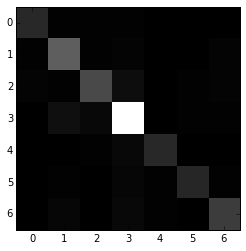

In [99]:
pl.gray()
_ = pl.imshow(cm, interpolation='nearest')